# Ejemplo "Hello World" de MONAI Auto3DSeg

En este notebook, proporcionaremos una demostración simple de cómo usar AutoRunner de Auto3DSeg para procesar un conjunto de datos simulado y generar resultados en minutos.

<img src="https://raw.githubusercontent.com/Project-MONAI/tutorials/main/auto3dseg/figures/workflow_v1.png" width="60%" />

## Descripción general

La segmentación de imágenes médicas 3D es una tarea importante con gran potencial para la comprensión clínica, el diagnóstico de enfermedades y la planificación quirúrgica. Auto3DSeg es una solución integral para la segmentación de imágenes médicas 3D a gran escala. Aprovecha los últimos avances en MONAI y GPUs para desarrollar y desplegar algoritmos de manera eficiente con un rendimiento de vanguardia, tanto para principiantes como para investigadores avanzados en el campo. Según las estadísticas de las recientes conferencias MICCAI, más del 60% de los artículos son aplicaciones de algoritmos de segmentación, y más de la mitad usan conjuntos de datos 3D. Tras trabajar muchos años en este campo, hemos lanzado la solución de segmentación Auto3DSeg, que requiere una entrada mínima del usuario (por ejemplo, raíz y lista de datos).

Auto3DSeg primero analiza la información global, como la intensidad del conjunto de datos, el tamaño de los datos y el espaciado. Luego genera carpetas de algoritmos en formato bundle de MONAI basándose en estadísticas de los datos y plantillas de algoritmos. Después, todos los algoritmos inician el entrenamiento del modelo para obtener los checkpoints con la mejor precisión de validación. Finalmente, el módulo de ensamblado selecciona los algoritmos mediante el ranking de los checkpoints entrenados y crea predicciones ensambladas. Mientras tanto, la solución ofrece diferentes niveles de experiencia para principiantes e investigadores avanzados. Ha sido probada en conjuntos de datos de imágenes médicas 3D a gran escala en varias modalidades diferentes.

- Marco unificado: Auto3DSeg es una solución autónoma de segmentación de imágenes médicas 3D con entrada mínima del usuario.
- Diseño modular flexible: los componentes de Auto3DSeg pueden usarse de forma independiente para satisfacer diferentes necesidades de los usuarios.
- Soporte para "Bring-Your-Own-Algorithm" (BYOA): hemos introducido una forma eficiente de incorporar algoritmos propios de los usuarios al framework de Auto3DSeg.
- Alta precisión y eficiencia: Auto3DSeg logra un rendimiento de vanguardia en la mayoría de las aplicaciones de segmentación de imágenes médicas 3D.

### Tabla de contenidos
* [Imports](#0.-Imports)
* [Configuración del dataset](#1.-Dataset-Setup)
* [Auto3DSeg](#2.-Auto3DSeg)
* [Inspeccionar predicciones](#3.-Inspect-Predictions)
* [Ejercicios opcionales](#4.-Optional-Exercises)
* [Conclusión](#5.-Conclusion)

### Configuración del sistema

Antes de continuar con el ejemplo, es importante asegurarse de que el controlador NVIDIA se haya instalado correctamente. Puedes verificarlo ejecutando el comando nvidia-smi, que debería proporcionar información sobre las GPUs en tu sistema.

In [ ]:
!nvidia-smi

### 0. Imports

En este notebook, solo necesitaremos importaciones mínimas de MONAI y utilidades, ya que Auto3DSeg gestionará el resto de importaciones durante sus distintas fases.

#### 0.1 Instalación
Antes de ejecutar el notebook, debemos asegurarnos de que los paquetes requeridos estén instalados en el entorno. Puedes instalar los paquetes necesarios ejecutando los siguientes comandos:

In [1]:
!python -c "import monai" || pip install -U "monai[fire, nibabel, yaml, tqdm, einops]==1.2"
!python -c "import yaml" || pip install -U "pyyaml"
!python -c "import psutil" || pip install -U "psutil"
!python -c "import tensorboard" || pip install -U "tensorboard"

#### 0.2 Imports

Importemos las librerías necesarias y usemos la función `print_config()` para asegurarnos de que todo está instalado correctamente.

In [2]:
import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from monai.data import create_test_image_3d

print_config()

MONAI version: 1.5.0
Numpy version: 2.3.1
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: /home/<username>/Workspace/Medical-Image-PGTD/.venv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Numpy version: 2.3.1
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: /home/<username>/Workspace/Medical-Image-PGTD/.venv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.0
Pillow version: 11.3.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: 1.7.2
psutil version: 7.0.0
pandas version: 2.3.1
einops version: 0.8.1
transf

### 1. Configuración del dataset

#### 1.1 Simular un pequeño dataset

Entrenar modelos de IA puede llevar mucho tiempo, así que para proporcionar una demostración rápida de Auto3DSeg en este notebook, simularemos un pequeño conjunto de datos y entrenaremos el modelo solo por unas pocas épocas. Ten en cuenta que el rendimiento del modelo entrenado puede no ser óptimo debido al tiempo de entrenamiento limitado, pero todo el pipeline se completará en minutos.

La variable `sim_datalist` contiene información sobre los datasets simulados. Incluye una lista de 24 imágenes de entrenamiento y etiquetas correspondientes, así como 8 imágenes y etiquetas de prueba. Los datos de entrenamiento se dividen en 2 folds, donde cada fold usa 12 imágenes para entrenamiento y 4 para validación. El tamaño de las dimensiones puede definirse con la variable `sim_dim`.

Para continuar con la configuración del dataset, seguiremos los pasos a continuación:

In [3]:
sim_datalist = {
    "testing": [
        {"image": "test_image_001.nii.gz", "label": "test_label_001.nii.gz"},
        {"image": "test_image_002.nii.gz", "label": "test_label_002.nii.gz"},
        {"image": "test_image_003.nii.gz", "label": "test_label_003.nii.gz"},
        {"image": "test_image_004.nii.gz", "label": "test_label_004.nii.gz"},
        {"image": "test_image_005.nii.gz", "label": "test_label_005.nii.gz"},
        {"image": "test_image_006.nii.gz", "label": "test_label_006.nii.gz"},
        {"image": "test_image_007.nii.gz", "label": "test_label_007.nii.gz"},
        {"image": "test_image_008.nii.gz", "label": "test_label_008.nii.gz"},

    ],
    "training": [
        {"fold": 0, "image": "tr_image_001.nii.gz", "label": "tr_label_001.nii.gz"},
        {"fold": 0, "image": "tr_image_002.nii.gz", "label": "tr_label_002.nii.gz"},
        {"fold": 0, "image": "tr_image_003.nii.gz", "label": "tr_label_003.nii.gz"},
        {"fold": 0, "image": "tr_image_004.nii.gz", "label": "tr_label_004.nii.gz"},
        {"fold": 0, "image": "tr_image_005.nii.gz", "label": "tr_label_005.nii.gz"},
        {"fold": 0, "image": "tr_image_006.nii.gz", "label": "tr_label_006.nii.gz"},
        {"fold": 0, "image": "tr_image_007.nii.gz", "label": "tr_label_007.nii.gz"},
        {"fold": 0, "image": "tr_image_008.nii.gz", "label": "tr_label_008.nii.gz"},
        {"fold": 0, "image": "tr_image_009.nii.gz", "label": "tr_label_009.nii.gz"},
        {"fold": 0, "image": "tr_image_010.nii.gz", "label": "tr_label_010.nii.gz"},
        {"fold": 0, "image": "tr_image_011.nii.gz", "label": "tr_label_011.nii.gz"},
        {"fold": 0, "image": "tr_image_012.nii.gz", "label": "tr_label_012.nii.gz"},
        {"fold": 1, "image": "tr_image_013.nii.gz", "label": "tr_label_013.nii.gz"},
        {"fold": 1, "image": "tr_image_014.nii.gz", "label": "tr_label_014.nii.gz"},
        {"fold": 1, "image": "tr_image_015.nii.gz", "label": "tr_label_015.nii.gz"},
        {"fold": 1, "image": "tr_image_016.nii.gz", "label": "tr_label_016.nii.gz"},
        {"fold": 1, "image": "tr_image_017.nii.gz", "label": "tr_label_017.nii.gz"},
        {"fold": 1, "image": "tr_image_018.nii.gz", "label": "tr_label_018.nii.gz"},
        {"fold": 1, "image": "tr_image_019.nii.gz", "label": "tr_label_019.nii.gz"},
        {"fold": 1, "image": "tr_image_020.nii.gz", "label": "tr_label_020.nii.gz"},
        {"fold": 1, "image": "tr_image_021.nii.gz", "label": "tr_label_021.nii.gz"},
        {"fold": 1, "image": "tr_image_022.nii.gz", "label": "tr_label_022.nii.gz"},
        {"fold": 1, "image": "tr_image_023.nii.gz", "label": "tr_label_023.nii.gz"},
        {"fold": 1, "image": "tr_image_024.nii.gz", "label": "tr_label_024.nii.gz"},
    ],
}

sim_dim = (64, 64, 64)

#### 1.2 Generar imágenes y etiquetas

Podemos utilizar la función `create_test_image_3d` de MONAI y `nib.Nifti1Image` de la librería nibabel para generar las imágenes 3D simuladas. Estas imágenes se guardarán en el `work_dir` especificado.

Como ya hemos definido nuestro conjunto de imágenes, podemos iterar sobre esos nombres de imágenes y etiquetas para crear los archivos correspondientes. En este caso, nuestros datos simulados consistirán en círculos aleatorios generados en un espacio 3D, que visualizaremos a continuación.

In [4]:
work_dir = "./helloworld_work_dir"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, "w") as f:
    json.dump(sim_datalist, f)

for d in sim_datalist["testing"] + sim_datalist["training"]:
    im, seg = create_test_image_3d(
        sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=1, random_state=np.random.RandomState(42)
    )
    image_fpath = os.path.join(dataroot_dir, d["image"])
    label_fpath = os.path.join(dataroot_dir, d["label"])
    nib.save(nib.Nifti1Image(im, affine=np.eye(4)), image_fpath)
    nib.save(nib.Nifti1Image(seg, affine=np.eye(4)), label_fpath)

#### 1.3 Inspeccionar los datos simulados

Para hacernos una idea de las imágenes simuladas en el conjunto de prueba, podemos seleccionar un corte de la imagen 3D y visualizarlo. Esto nos dará una vista previa de los datos simulados.

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


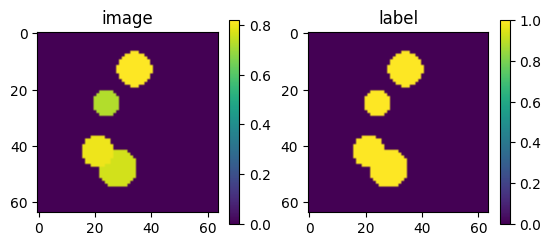

In [5]:
img_nib = nib.load(os.path.join(dataroot_dir, sim_datalist["testing"][0]["image"]))
lbl_nib = nib.load(os.path.join(dataroot_dir, sim_datalist["testing"][0]["label"]))
img = np.array(img_nib.dataobj)
lbl = np.array(lbl_nib.dataobj)
plt.subplot(1, 2, 1)
plt.imshow(img[32])
plt.title("image")
cbar = plt.colorbar(shrink=0.55)
plt.subplot(1, 2, 2)
plt.imshow(lbl[32])
plt.title("label")
cbar = plt.colorbar(shrink=0.55)

## 2. Auto3DSeg
#### 2.1 Usando el pipeline AutoRunner de Auto3DSeg

La clase `AutoRunner` proporciona una interfaz para ejecutar el pipeline de Auto3DSeg. Ofrece alta configurabilidad y requiere una entrada mínima del usuario para comenzar. `AutoRunner` configura automáticamente múltiples redes neuronales y realiza entrenamiento multi-fold para lograr un rendimiento de vanguardia. En este ejemplo, buscamos completar el pipeline en dos a cuatro minutos, por lo que necesitamos hacer algunas personalizaciones.

Configuremos el `AutoRunner` con los siguientes ajustes:

In [6]:
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    }
)

2025-07-16 17:18:44,232 - INFO - AutoRunner using work directory /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir
2025-07-16 17:18:44,235 - INFO - Found num_fold 2 based on the input datalist /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/sim_datalist.json.
2025-07-16 17:18:44,236 - INFO - Setting num_fold 2 based on the input datalist /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/sim_datalist.json.
2025-07-16 17:18:44,235 - INFO - Found num_fold 2 based on the input datalist /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/sim_datalist.json.
2025-07-16 17:18:44,236 - INFO - Setting num_fold 2 based on the input datalist /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/sim_datalist.json.
2025-07-16 17:18:44,248 - INFO - Using user defined command running prefix , will override other settings
2025-07-16 17:18:44,248 - INFO - Using user defined command running prefix , will override o

#### 2.2 Sobrescribir los parámetros de entrenamiento

Si deseas usar más de una GPU, puedes modificar la variable de entorno `CUDA_VISIBLE_DEVICES` o eliminar la clave para utilizar todos los dispositivos disponibles. Sin embargo, asegúrate de que el número de GPUs sea menor que el número de particiones en el dataset para evitar conflictos.

En esta sección, puedes personalizar los ajustes de `AutoRunner` para alinearlos con tu caso de uso específico. Para este ejemplo, usaremos números pequeños para explorar la funcionalidad y el uso de Auto3DSeg. Sin embargo, en escenarios reales, deberías ajustar estos números según el tamaño del dataset, la dificultad de la tarea y el número de GPUs disponibles.

In [7]:
max_epochs = 2

train_param = {
    "num_epochs_per_validation": 1,
    "num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)

#### 2.3 Iniciar el pipeline de Auto3DSeg

Después de establecer los parámetros deseados, podemos iniciar el pipeline de Auto3DSeg usando el método `runner.run()`. El `AutoRunner` ejecutará todos los pasos necesarios para entrenar el modelo.

Cada módulo de Auto3DSeg puede usarse individualmente para diferentes propósitos, y las funciones/métodos dentro de los componentes pueden ser personalizados por los usuarios.

El pipeline de Auto3DSeg consiste en los siguientes pasos:

- Paso 1: [Analizador de datos](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/data_analyzer.md)
- Paso 2: [Generación de algoritmos](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/algorithm_generation.md)
- Paso 3: [Entrenamiento, validación e inferencia del modelo](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/bundle.md)
- Paso 4 (Opcional): [Optimización de hiperparámetros](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/hpo.md)
- Paso 5: [Ensamblado de modelos](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/ensemble.md)

In [8]:
runner.run()

2025-07-16 17:18:49,160 - INFO - Running data analysis...
2025-07-16 17:18:49,161 - INFO - Found 1 GPUs for data analyzing!
2025-07-16 17:18:49,161 - INFO - Found 1 GPUs for data analyzing!


100%|██████████| 24/24 [00:00<00:00, 29.82it/s]

2025-07-16 17:18:50,023 - INFO - Writing data stats to /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/datastats.yaml.
2025-07-16 17:18:50,027 - INFO - Writing by-case data stats to /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/datastats_by_case.yaml, this may take a while.
2025-07-16 17:18:50,027 - INFO - Writing by-case data stats to /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/datastats_by_case.yaml, this may take a while.
2025-07-16 17:18:50,060 - INFO - BundleGen from https://github.com/Project-MONAI/research-contributions/releases/download/algo_templates/21ed8e5.tar.gz
2025-07-16 17:18:50,060 - INFO - BundleGen from https://github.com/Project-MONAI/research-contributions/releases/download/algo_templates/21ed8e5.tar.gz



algo_templates.tar.gz: 104kB [00:00, 276kB/s]                              

2025-07-16 17:18:50,943 - INFO - Downloaded: /tmp/tmpfwoi6p67/algo_templates.tar.gz
2025-07-16 17:18:50,944 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpfwoi6p67/algo_templates.tar.gz.
2025-07-16 17:18:50,945 - INFO - Writing into directory: /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir.
2025-07-16 17:18:50,944 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpfwoi6p67/algo_templates.tar.gz.
2025-07-16 17:18:50,945 - INFO - Writing into directory: /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir.
2025-07-16 17:18:51,020 - INFO - Generated:/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/dints_0
2025-07-16 17:18:51,020 - INFO - Generated:/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/dints_0


2025-07-16 17:18:51,036 - INFO - Generated:/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/segresnet_0
2025-07-16 17:18:51,046 - INFO - segresnet2d_0 is skipped! SegresNet2D is skipped due to median spacing of [1.0, 1.0, 1.0],  which means the dataset is not highly anisotropic, e.g. spacing[2] < 3*(spacing[0] + spacing[1])/2) .
2025-07-16 17:18:51,046 - INFO - segresnet2d_0 is skipped! SegresNet2D is skipped due to median spacing of [1.0, 1.0, 1.0],  which means the dataset is not highly anisotropic, e.g. spacing[2] < 3*(spacing[0] + spacing[1])/2) .
2025-07-16 17:18:51,067 - INFO - Generated:/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/swinunetr_0
2025-07-16 17:18:51,067 - INFO - Generated:/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/swinunetr_0
2025-07-16 17:18:51,080 - INFO - The keys num_warmup_epochs cannot be found in the /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/dints_0/configs/hyper_

2025/07/16 17:18:54 INFO mlflow.tracking.fluent: Experiment with name 'Auto3DSeg' does not exist. Creating a new experiment.
dints_0 - training ...: 100%|██████████| 2/2 [00:18<00:00,  9.39s/round]


dints_0 - validation at original spacing/resolution


2025-07-16 17:19:19,789 - WARNING - dints_0 - training: finished


2025-07-16 17:19:20,768 - INFO - ['python', '/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/segresnet_0/scripts/train.py', 'run', "--config_file='/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/segresnet_0/configs/hyper_parameters.yaml'", '--num_epochs_per_validation=1', '--num_images_per_batch=2', '--num_epochs=2', '--num_warmup_epochs=1']


2025/07/16 17:19:23 INFO mlflow.tracking.fluent: Experiment with name 'Auto3DSeg' does not exist. Creating a new experiment.
segresnet_0 - training: 100%|██████████| 2/2 [00:06<00:00,  3.37s/epoch]


2025-07-16 17:19:30,885 - INFO - ['python', '/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/swinunetr_0/scripts/train.py', 'run', "--config_file='/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/swinunetr_0/configs/hyper_parameters.yaml,/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/swinunetr_0/configs/network.yaml,/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/swinunetr_0/configs/transforms_infer.yaml,/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/swinunetr_0/configs/transforms_train.yaml,/home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/swinunetr_0/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_images_per_batch=2', '--num_epochs=2', '--num_warmup_epochs=1']
2025-07-16 17:19:46,353 - INFO - Downloaded: /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/swinunetr_0/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4

2025/07/16 17:19:46 INFO mlflow.tracking.fluent: Experiment with name 'Auto3DSeg' does not exist. Creating a new experiment.
swinunetr_0 - training ...: 100%|██████████| 2/2 [00:10<00:00,  5.18s/round]
2025-07-16 17:19:58,939 - WARNING - swinunetr_0 - training: finished
2025-07-16 17:19:58,939 - WARNING - swinunetr_0 - training: finished


2025-07-16 17:19:59,902 - INFO - Ensembling using single GPU!
2025-07-16 17:19:59,903 - INFO - The output_dir is not specified. /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/ensemble_output will be used to save ensemble predictions.
2025-07-16 17:19:59,904 - INFO - Directory /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/ensemble_output is created to save ensemble predictions
2025-07-16 17:19:59,903 - INFO - The output_dir is not specified. /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/ensemble_output will be used to save ensemble predictions.
2025-07-16 17:19:59,904 - INFO - Directory /home/emi/Workspace/Medical-Image-PGTD/notebooks/helloworld_work_dir/ensemble_output is created to save ensemble predictions
2025-07-16 17:19:59,915 - INFO - Auto3Dseg picked the following networks to ensemble:
2025-07-16 17:19:59,915 - INFO - swinunetr_0
2025-07-16 17:19:59,916 - INFO - Auto3Dseg ensemble prediction outputs will be save

Ensembling (rank 0)...: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]
2025-07-16 17:20:02,929 - INFO - Auto3Dseg pipeline is completed successfully.
Ensembling (rank 0)...: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]
2025-07-16 17:20:02,929 - INFO - Auto3Dseg pipeline is completed successfully.


## 3. Inspección de predicciones

Ahora que hemos completado el pipeline de Auto3DSeg y obtenido la salida ensamblada, podemos inspeccionar las predicciones y comparar los resultados.

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword


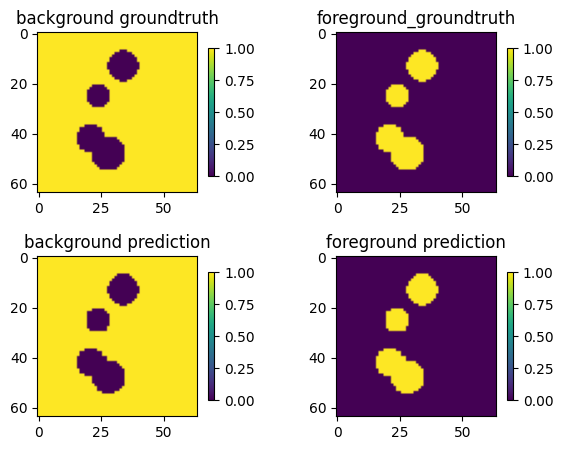

In [9]:
image_name = sim_datalist["testing"][0]["image"].split(".")[0]
prediction_nib = nib.load(os.path.join(work_dir, "ensemble_output", image_name + "_ensemble" + ".nii.gz"))
pred = np.array(prediction_nib.dataobj)

img_slice32 = lbl[32] == 0
label_slice32 = lbl[32] == 1
background_slice32 = pred[32, :, :, 0] if pred.ndim == 4 else pred[32] == 0
foreground_slice32 = pred[32, :, :, 1] if pred.ndim == 4 else pred[32] == 1

plt.subplot(2, 2, 1)
plt.imshow(img_slice32)
plt.title("background groundtruth")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 2)
plt.imshow(label_slice32)
plt.title("foreground_groundtruth")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 3)
plt.imshow(background_slice32)
plt.title("background prediction")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 4)
plt.imshow(foreground_slice32)
plt.title("foreground prediction")
cbar = plt.colorbar(shrink=0.8)
# set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

## Conclusión
¡Felicidades! Has completado todo el pipeline de Auto3DSeg. A lo largo del proceso, observaste cómo los algoritmos aprendieron del dataset y generaron predicciones tanto para los vóxeles de fondo como de primer plano. 

Auto3DSeg y AutoRunner ofrecen alta configurabilidad, permitiéndote personalizar varios aspectos del pipeline. Para mejorar tus resultados, puedes considerar aumentar el tiempo de entrenamiento, explorar diferentes métodos de ensamblado o utilizar optimización de hiperparámetros a través de las APIs de AutoRunner o el módulo Auto3DSeg.

Si te interesan casos de uso reales de Auto3DSeg, puedes encontrar más información y tutoriales en la [carpeta de tutoriales de Auto3DSeg](https://github.com/Project-MONAI/tutorials/tree/main/auto3dseg/).